In [14]:
# all imports and constants
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

## Data Handling and Displaying

**Task:**

1. Read Birkshire Hathaway CSV file.
2. Cure the Data.
    - Convert time format to Julian.
    - Add a "Mid" feature that averages the open and close prices.
    - Drop "Open" and "Close" features.
3. Display Data.
    - Print number of days of data.
    - Print the data header before and after curing.
    - Plot "Mid" the mid feature over julian time.

Number of entries: 2408


Raw data:
         Date        Open       Close
0  2015-01-02  151.500000  149.169998
1  2015-01-05  148.809998  147.000000
2  2015-01-06  147.639999  146.839996
3  2015-01-07  147.940002  148.880005
4  2015-01-08  150.600006  151.369995
5  2015-01-09  151.649994  149.470001
6  2015-01-12  149.960007  148.279999
7  2015-01-13  149.949997  148.630005
8  2015-01-14  147.270004  147.820007
9  2015-01-15  148.529999  147.580002


After curating data:
      Date         Mid
0  2457024  150.334999
1  2457027  147.904999
2  2457028  147.239998
3  2457029  148.410004
4  2457030  150.985001
5  2457031  150.559998
6  2457034  149.120003
7  2457035  149.290001
8  2457036  147.545006
9  2457037  148.055000
3496


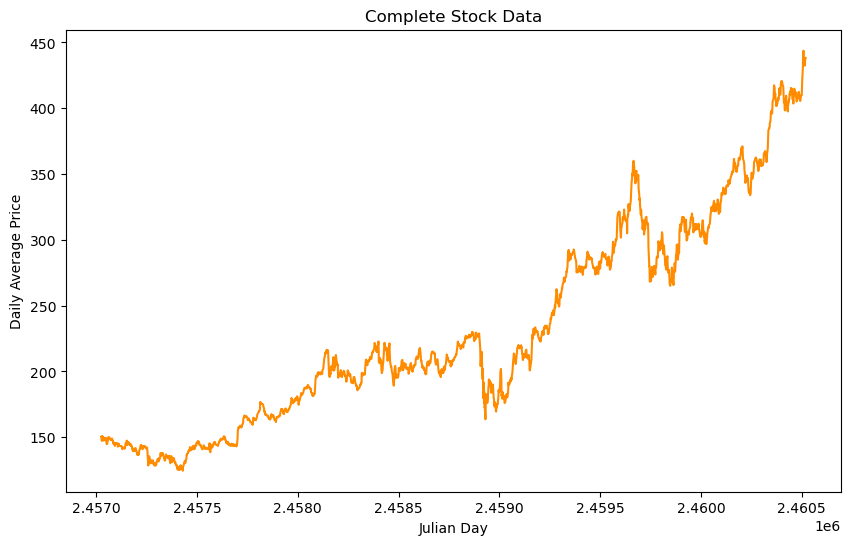

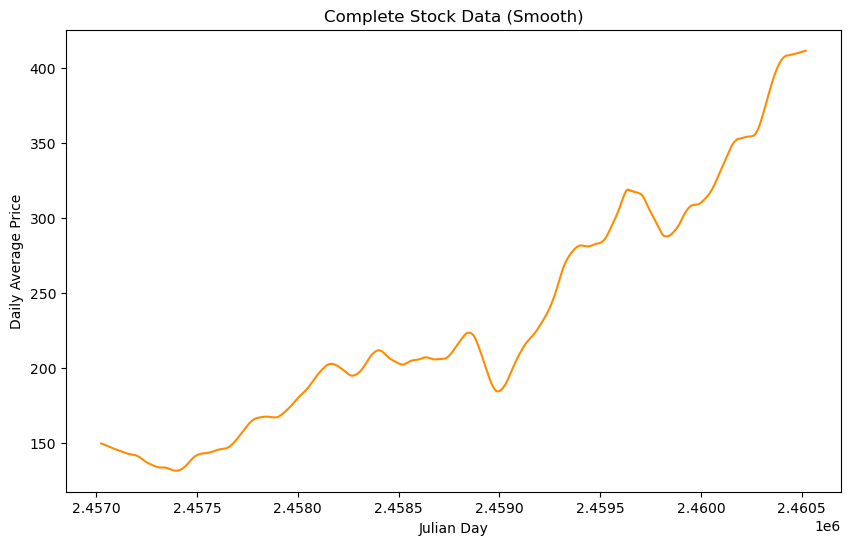

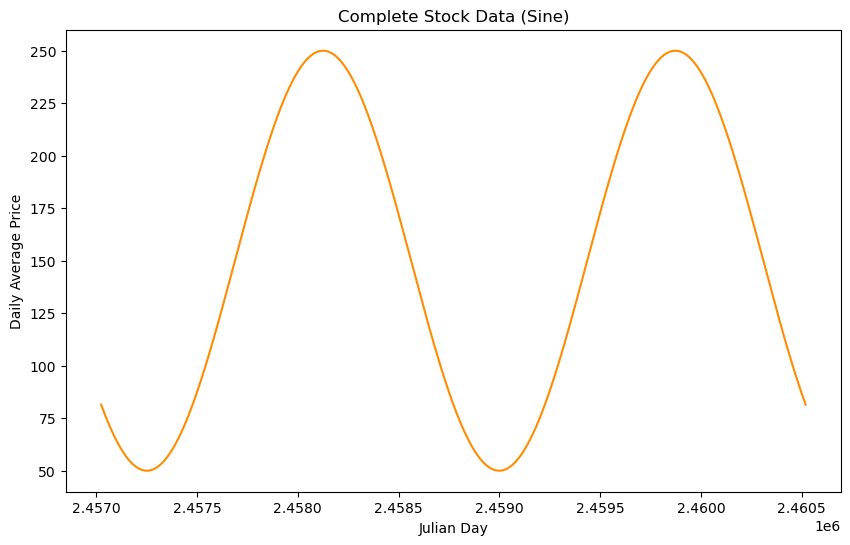

In [15]:
# Parse CSV
# Data pulled from https://www.kaggle.com/datasets/umerhaddii/berkshire-hathaway-stock-price-data
# Using the data curation from https://github.com/hemangjoshi37a/TrendMaster/blob/main/trendmaster/data_loader.py
firstDF = pd.read_csv('stocks.csv')[['Date', 'Open', 'Close']]
print("Number of entries:", len(firstDF['Date'].values))
print("\n\nRaw data:")
print(firstDF.head(10))

# Get Julian day and average the open and close values for the day as a new feature, "Mid"
firstDF['Date'] = firstDF['Date'].apply(lambda x: pd.to_datetime(x).to_julian_date().astype(int))
firstDF['Mid'] = (firstDF['Open'] + firstDF['Close']) / 2
firstDF = firstDF.drop(columns=['Open', 'Close'])
print("\n\nAfter curating data:")
print(firstDF.head(10))

# Get arrays of dates and stock prices
dates = firstDF['Date'].values
prices = firstDF['Mid'].values
lowess = sm.nonparametric.lowess
smooth_data = lowess(prices, dates, frac=.05)
prices_smooth = list(zip(*smooth_data))[1]
lapse = dates[-1].item() - dates[0].item()
print(lapse)
prices_sine = 100 * np.sin(dates / lapse * 4 * 3.14159265) + 150

# Display data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, color="darkorange")
plt.title("Complete Stock Data")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

# Display smooth data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices_smooth, color="darkorange")
plt.title("Complete Stock Data (Smooth)")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

# Display sine data
plt.figure(figsize=(10, 6))
plt.plot(dates, prices_sine, color="darkorange")
plt.title("Complete Stock Data (Sine)")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

## Creating and Printing X and Y

**Task:**

1. idk man



In [24]:
def createXY(prices: np.ndarray, real_prices: np.ndarray, sampleSize: int) -> tuple[np.ndarray, np.ndarray]:
    numSamples = int(len(prices) / (sampleSize + 1))
    X = np.full((numSamples, sampleSize), np.nan)
    y = np.full((numSamples), np.nan)
    for i in range(0, numSamples):
        start = i * (sampleSize + 1)
        X[i] = (prices[start : start + sampleSize])
        y[i] = (int(real_prices[start + sampleSize] > real_prices[start + sampleSize - 1]))
    
    return X, y

## Evaluating Models

**Task:**

1. idk man

In [25]:
def predict_linReg(X_test: np.ndarray) -> np.ndarray:
    model = LinearRegression()
    pred = np.full((X_test.shape[0]), np.nan)
    days = np.linspace(0, X_test.shape[1] - 1, X_test.shape[1], dtype=int)
    for i in range(X_test.shape[0]):
        model.fit(days.reshape(-1, 1), X_test[i].flatten())
        pred[i] = int(model.coef_[0] > 0)
    return pred


def eval_models(prices: np.ndarray, real_prices: np.ndarray, sampleSize: int, numSplits: int, random_state: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    # create classification models
    clf = DecisionTreeClassifier(random_state=random_state)
    forest = RandomForestClassifier(max_depth=2, random_state=random_state)
    logReg = LogisticRegression(random_state=random_state)

    # perform k-fold cross validation
    X, y = createXY(prices, real_prices, sampleSize)
    stats_clf = cross_val_score(clf, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    stats_forest = cross_val_score(forest, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    stats_logReg = cross_val_score(logReg, X, y, scoring='accuracy', cv=KFold(n_splits=numSplits), n_jobs=-1)
    acc_linReg = accuracy_score(y, predict_linReg(X))

    return stats_clf, stats_forest, stats_logReg, acc_linReg

## Grid Optimization

**Task:**

1. idk man

Best accuracy: Linear Regression at 0.742 with standard deviation of -1.000 and sample size of 76
Average performances:

	Decision Tree: 0.4838964878489522
	Random Forest: 0.48276081483848926
	Logistic Regression: 0.5017159364961332
	Linear Regression: 0.5302919350729622


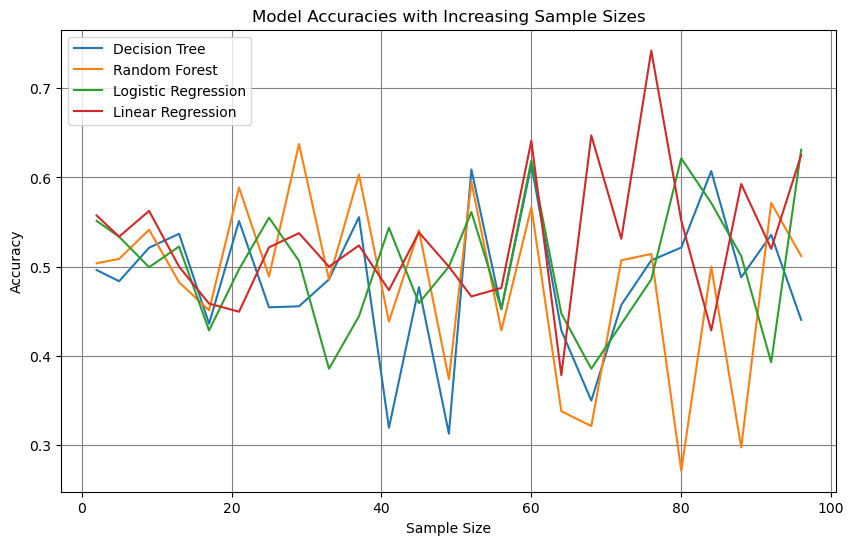

In [26]:
def grid_optim(prices: np.ndarray, real_prices: np.ndarray):
    # define hyperparameters
    RANDOM_STATE = 42
    NUM_ITERATIONS = 25
    MAX_SAMPLESIZE = 100
    NUM_SPLITS = 7

    # start grid optimization for sample size
    best_model = ""
    max_acc = -1
    max_std = -1
    max_size = -1
    final_accs = [[], [], [], []]
    sampleSizes = []
    for i in range(NUM_ITERATIONS):
        sampleSize = int(i * (MAX_SAMPLESIZE - 2) / NUM_ITERATIONS + 2)
        stats_clf, stats_forest, stats_logReg, acc_linReg = eval_models(prices, real_prices, sampleSize, NUM_SPLITS, RANDOM_STATE)

        if stats_clf.mean() > max_acc:
            best_model = "Decision Tree"
            max_acc = stats_clf.mean()
            max_std = stats_clf.std()
            max_size = sampleSize
        if stats_forest.mean() > max_acc:
            best_model = "Random Forest"
            max_acc = stats_forest.mean()
            max_std = stats_forest.std()
            max_size = sampleSize
        if stats_logReg.mean() > max_acc:
            best_model = "Logistic Regression"
            max_acc = stats_logReg.mean()
            max_std = stats_logReg.std()
            max_size = sampleSize
        if acc_linReg > max_acc:
            best_model = "Linear Regression"
            max_acc = acc_linReg
            max_std = -1
            max_size = sampleSize

        final_accs[0].append(stats_clf.mean())
        final_accs[1].append(stats_forest.mean())
        final_accs[2].append(stats_logReg.mean())
        final_accs[3].append(acc_linReg)
        sampleSizes.append(sampleSize)

    print(f"Best accuracy: {best_model} at {max_acc:.3f} with standard deviation of {max_std:.3f} and sample size of {max_size}")
    print("Average performances:\n")
    print(f"\tDecision Tree: {np.mean(final_accs[0])}")
    print(f"\tRandom Forest: {np.mean(final_accs[1])}")
    print(f"\tLogistic Regression: {np.mean(final_accs[2])}")
    print(f"\tLinear Regression: {np.mean(final_accs[3])}")


    # plot results
    plt.figure(figsize=(10, 6))
    plt.plot(sampleSizes, final_accs[0], label="Decision Tree")
    plt.plot(sampleSizes, final_accs[1], label="Random Forest")
    plt.plot(sampleSizes, final_accs[2], label="Logistic Regression")
    plt.plot(sampleSizes, final_accs[3], label="Linear Regression")
    plt.grid(color="grey")
    plt.xlabel("Sample Size")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracies with Increasing Sample Sizes")
    plt.legend()
    plt.show()


grid_optim(prices, prices)

## Explanation: Smoothness

**Task:**

1. idk man

Best accuracy: Logistic Regression at 0.959 with standard deviation of 0.065 and sample size of 49
Average performances:

	Decision Tree: 0.4810733787942199
	Random Forest: 0.501428481988944
	Logistic Regression: 0.8761697449090349
	Linear Regression: 0.8461342997661581


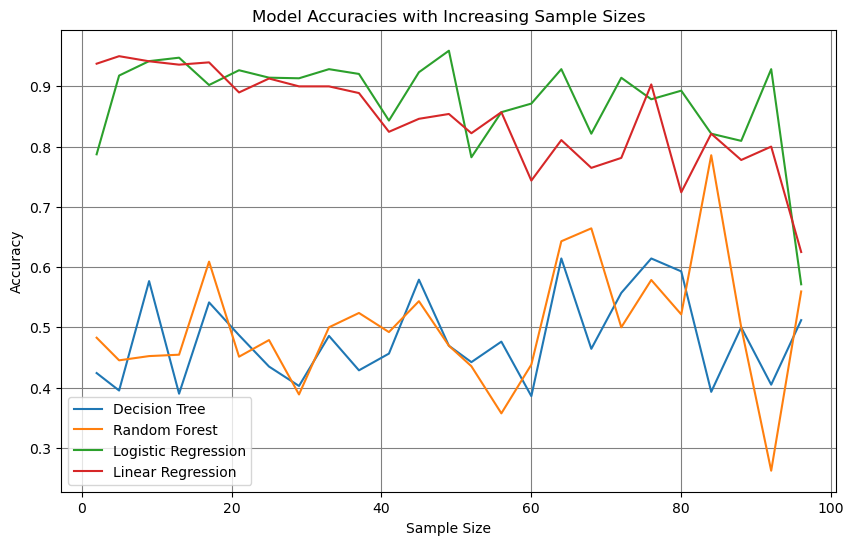

In [ ]:
grid_optim(prices_smooth, prices_smooth)

Best accuracy: Logistic Regression at 0.959 with standard deviation of 0.065 and sample size of 49
Average performances:

	Decision Tree: 0.4810733787942199
	Random Forest: 0.501428481988944
	Logistic Regression: 0.8761697449090349
	Linear Regression: 0.8461342997661581


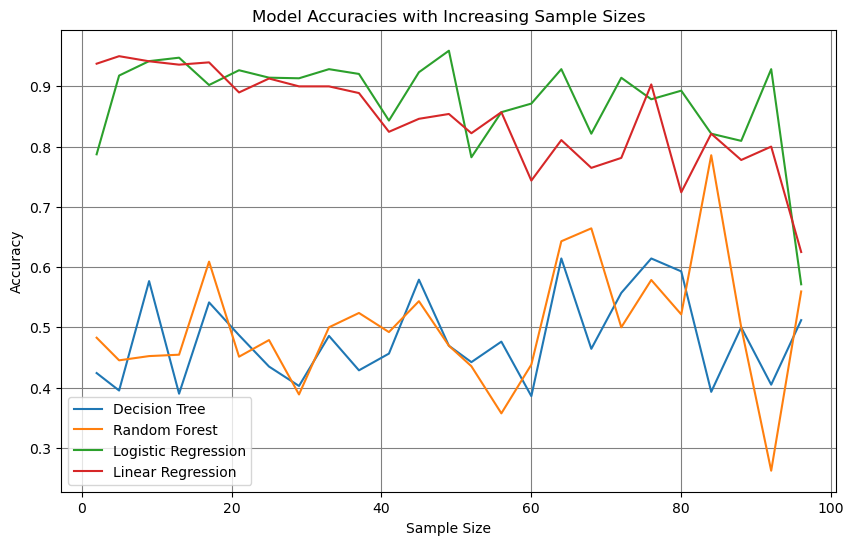

In [ ]:
grid_optim(prices_smooth, prices)

## Explanation: Global Trends

**Task:**

1. idk man

Best accuracy: Decision Tree at 0.845 with standard deviation of 0.137 and sample size of 96
Average performances:

	Decision Tree: 0.5257966468010902
	Random Forest: 0.5146713638495771
	Logistic Regression: 0.5308834770570574
	Linear Regression: 0.4997846455047668


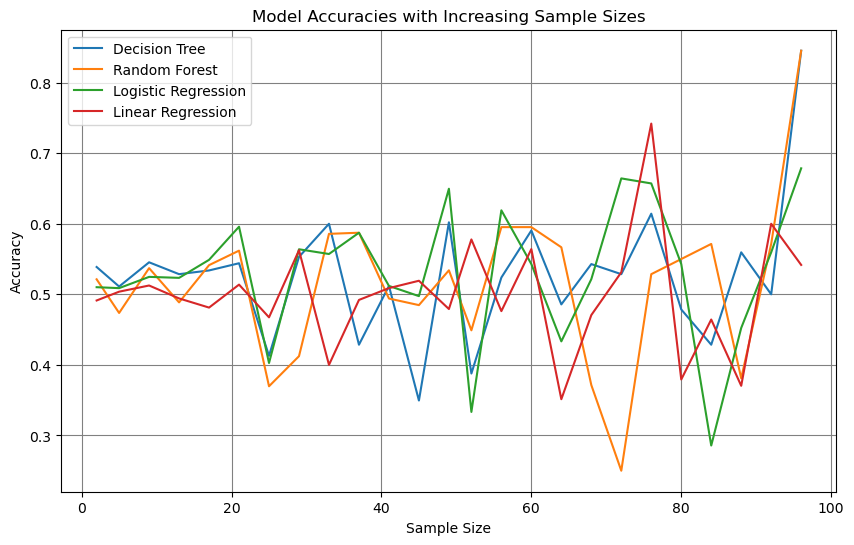

In [ ]:
grid_optim(prices_sine, prices_sine)